In [1]:
# import the required libraries
import numpy as np
import random
import os
import json
import tensorflow as tf
import keras
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# setting for autoreload
%reload_ext autoreload
%autoreload 2

/Users/hiroki/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)
print("Keras Version: ", keras.__version__)

INFO:tensorflow:TensorFlow Version: 1.12.0
Keras Version:  2.2.4


In [3]:
# import command line tools
from sketch_rnn_model import *
from train import *
from utils import *

In [4]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [5]:
data_dir = 'data'
model_dir = 'models/owl'

In [6]:
[train_set, valid_set, test_set, hps] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 70000/2500/2500 from owl.npz
INFO:tensorflow:Dataset combined: 75000 (70000/2500/2500), avg len 85
INFO:tensorflow:model_params.max_seq_len 148.
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
INFO:tensorflow:normalizing_scale_factor 42.7029.


In [7]:
model = SketchRNN(hps)
weights = 'models/owl/model_2.hdf5'

In [8]:
def encode(model, input_strokes):
  strokes = to_big_strokes(input_strokes, max_len=hps.max_seq_len)
  draw_strokes(to_normal_strokes(strokes))
  strokes = np.expand_dims(strokes, axis=0)
  encoder_model = model.encoder
  _, _, z = encoder_model.predict(strokes)
  return z

In [9]:
def decode(model, z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  sample_strokes = sample(model, hps, weights, seq_len=hps.max_seq_len, temperature=temperature,
                          greedy_mode=False, z=z_input)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [10]:
# Since sample function clears session every time it runs, 
# you have to run this code to reset the model after sampling.
def reset_model():
  model = SketchRNN(hps)
  model.sketch_rnn_model.load_weights(weights)
  return model

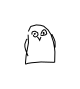

In [14]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

In [15]:
model = reset_model()

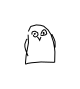

In [16]:
z = encode(model, stroke)

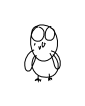

In [17]:
_ = decode(model, z, temperature=0.2)

Create generated grid at various temperatures from 0.1 to 1.0

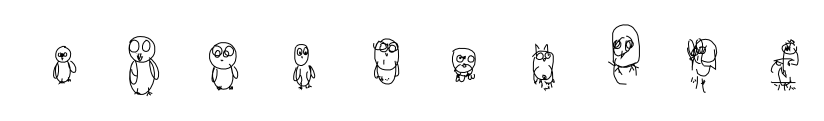

In [18]:
stroke_list = []
for i in range(10):
  model = reset_model()
  stroke_list.append([decode(model, z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Now interpolate between owl $z_0$ and owl $z_1$

In [19]:
model = reset_model()

In [20]:
z0 = z

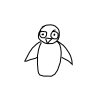

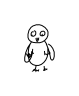

In [21]:
stroke = test_set.random_sample()
z1 = encode(model, stroke)
_ = decode(model, z1)

In [22]:
z_list = [] # interpolate between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(lerp(z0, z1, t))

In [23]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  model = reset_model()
  reconstructions.append([decode(model, z_list[i], draw_mode=False, temperature=0.3), [0, i]])

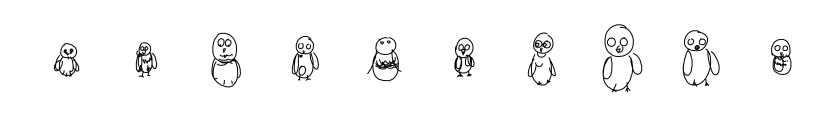

In [24]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)